In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import chess
import chess.svg
import chess.engine
from IPython.core.display import SVG
from IPython.display import display

In [2]:
def loadSegmentImage(image_path, thresh=15, plt_flag=True):
    img = cv.imread(image_path)
    img_hsv = cv.cvtColor(img.copy(),cv.COLOR_BGR2HSV)
    img_s = img_hsv[:,:,1]
    img_thresh = ((img_s > thresh)).astype(np.uint8)
    cntrs,_ = cv.findContours(img_thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    if plt_flag:
        plt.imshow(img_thresh,cmap='gray')
        plt.title('Segmented based on Saturation')
        plt.show()
        
    max_cont = 0
    idx = 0
    max_area = 0

    for i, cont in enumerate(cntrs):
        max_cont = max(max_cont, len(cont))
        if cv.contourArea(cont) > max_area:
            max_area = cv.contourArea(cont)
            idx = i 
 
    empty_image = np.zeros_like(img)
    im_cont = cv.cvtColor(cv.drawContours(np.copy(empty_image),\
             cntrs, idx, (255,255,255), 1), cv.COLOR_RGB2GRAY) #white_channel
    
    if plt_flag:
        plt.imshow(im_cont, cmap="gray")
        plt.title('Max Area Contour')
        plt.show()
    
    return img,cntrs,idx

In [3]:
def getContourCorners(img, contours, idx, plt_flag=True):
	top_left = None
	tl_val = 1e9
	top_right = None
	tr_val = 1e9
	bottom_right = None
	br_val = 0
	bottom_left = None
	bl_val = 0

	best_cont = contours[idx].squeeze()

	for i in range(len(best_cont)):
		x = best_cont[i][1]
		y = best_cont[i][0]
		if br_val <  x + y:
			br_val = x + y
			bottom_right = [y, x]
		
		if bl_val <  x - y:
			bl_val = x - y
			bottom_left = [y, x]
		
		if tr_val >  x - y:
			tr_val = x - y
			top_right = [y, x]
		
		if tl_val > x + y:
			tl_val = x + y
			top_left = [y, x]
	
	corner_img = cv.circle(np.copy(img), bottom_left, 2, (255, 0, 0), -1)
	corner_img = cv.circle(corner_img, bottom_right, 2, (255, 0, 0), -1)
	corner_img = cv.circle(corner_img, top_left, 2, (255, 0, 0), -1)
	corner_img = cv.circle(corner_img, top_right, 2, (255, 0, 0), -1)

	if plt_flag:
		plt.imshow(corner_img)
		plt.title("Contour Corners Detected")
		plt.show()
	
	corners = np.array([top_left, top_right, bottom_left, bottom_right])
	return corners

In [4]:
def fitLines(bird_eye_chess, buffer_zone=1, thresh=0.15, plt_flag=True):
    
    cdstPM = cv.Canny(cv.blur(np.copy(bird_eye_chess), (4,4)), 100, 150, None, 3)
    cdstPM = (cdstPM>0).astype(np.uint8)*255 #binary image


    if plt_flag:
        plt.imshow(cdstPM)
        plt.title('Canny Edge Detection')
        plt.show()
    
    newImg = np.zeros_like(cdstPM)
    h = newImg.shape[0]
    w = newImg.shape[1]

    lines_x = []
    i = 0
    #Vertical Scan 
    while(i < w):
        left = max(0,i-buffer_zone)
        right = min(w-1,i+buffer_zone)
        count = np.count_nonzero(cdstPM[:,left:right+1] == 255)
        if count >= thresh*(2*buffer_zone+1)*h:
            newImg[:,i] = 255
            lines_x.append(i)
            i += 40
        i += 1

    lines_y = []
    i = 0
    #Horizontal Scan 
    while(i < h):
        top = max(0,i-buffer_zone)
        bottom = min(h-1,i+buffer_zone)
        count = np.count_nonzero(cdstPM[top:bottom+1] == 255)
        if count >= thresh*(2*buffer_zone+1)*w:
            newImg[i,:] = 255
            lines_y.append(i)
            i += 40
        i += 1
    
    if plt_flag:
        plt.imshow(newImg, cmap="gray")
        plt.title('Chessboard Edges Detected')
        plt.show()

    return lines_x, lines_y


In [5]:
def getCellName(pixel_x, pixel_y, lines_x, lines_y):
	cell_x = ''
	cell_y = ''

	i = 0
	while(i < len(lines_x)-1):
		if lines_x[i] <= pixel_x <= lines_x[i+1]:
			cell_x = str(i+1)
		i+=1
	
	i = 0
	while(i < len(lines_y)-1):
		if lines_y[i] <= pixel_y <= lines_y[i+1]:
			cell_y = chr(ord('a') + i)
		i+=1
	
	return cell_x, cell_y

In [6]:
def getCellCentroid(file,rank,lines_x,lines_y):
    i = int(rank)
    j = ord(file) - ord('a')
    x = (lines_x[i-1] + lines_x[i])*0.5
    y = (lines_y[j] + lines_y[j+1])*0.5

    return int(x),int(y)

In [7]:
def find_bounding_box_coords(labels, img, plt_flag=True):
    
    bb_points = np.zeros((labels.shape[0], 8))
    for i in range(labels.shape[0]):
        xc = labels[i][1]
        yc = labels[i][2]
        h = labels[i][3]/2
        w = labels[i][4]/2
        bb_points[i, :] = np.array([
            xc-h, yc-w,
            xc+h, yc-w,
            xc+h, yc+w,
            xc-h, yc+w,
        ])
        
    bb_points *= 414
    
    if plt_flag:
        plt.imshow(img)
        plt.scatter(bb_points[:,0],bb_points[:,1])
        plt.scatter(bb_points[:,2],bb_points[:,3])
        plt.scatter(bb_points[:,4],bb_points[:,5])
        plt.scatter(bb_points[:,6],bb_points[:,7])
        plt.title("Bounding Boxes detected from YOLOv5")
        plt.show()

    return bb_points

In [8]:
def transform_bounding_box_coords(bb_points, H):
    projected_bb_points = np.zeros_like(bb_points)
    for i in range(0,8,2):
        pts = np.vstack([bb_points[:,i],bb_points[:,i+1],np.ones(bb_points.shape[0])]) #homogenous
        ph = H @ pts
        projected_bb_points[:,i] = ph[0]/ph[2]
        projected_bb_points[:,i+1] = ph[1]/ph[2]
    return projected_bb_points

In [9]:
def fill_chessboard_squares(im_warped, projected_bb_points, labels, lines_x, lines_y, pieceNames, plt_flag=True):
    if plt_flag:
        plt.imshow(im_warped)

    center_x = (projected_bb_points[:,0] + projected_bb_points[:,4])*0.5
    center_y = (projected_bb_points[:,1] + projected_bb_points[:,5])*0.5
    base_y = (projected_bb_points[:,7]+projected_bb_points[:,5])*0.5
    board = chess.Board()
    board.clear_board()
    for i in range(center_y.shape[0]):
        px = center_x[i]
        py = (center_y[i] + base_y[i])*0.5
        x,y = getCellName(px,py,lines_x,lines_y)
        p = pieceNames[int(labels[i][0])]
        board.set_piece_at(chess.parse_square(f'{y}{x}'),chess.Piece.from_symbol(p))
        if plt_flag:
            plt.text(px,py,pieceNames[int(labels[i][0])]+' '+str(y)+str(x))
    
    if plt_flag:
        plt.scatter(center_x,(center_y+base_y)*0.5)
        plt.title("Points used to determine squares")
        plt.show()
        
    return board

In [10]:
def chess_engine_generated_move(im_warped, board, H, lines_x, lines_y, file_pth, turn=chess.WHITE, plt_flag=True):
    engine = chess.engine.SimpleEngine.popen_uci("/raid/home/niranjan20090/CV/stockfish/stockfish_15.1_linux_x64/stockfish-ubuntu-20.04-x86-64")
    board.turn = turn
    res = engine.play(board,chess.engine.Limit(time=2.0))
    best_move = res.move
    best_move = str(best_move)
    frompt = getCellCentroid(best_move[0],best_move[1],lines_x,lines_y)
    topt = getCellCentroid(best_move[2],best_move[3],lines_x,lines_y)
    im_warped_w_arrow = cv.arrowedLine(np.copy(cv.cvtColor(im_warped, cv.COLOR_BGR2RGB)),frompt,topt,(0,255,0),5)
    im_warped_w_arrow_reversed = cv.warpPerspective(np.copy(im_warped_w_arrow), np.linalg.inv(H), (414,414))
    if plt_flag:
        # plt.imsave(f"dataset/test/next_moves_generated/{file_pth}.jpg", im_warped_w_arrow_reversed)
        plt.imshow(im_warped_w_arrow_reversed)
        plt.title("Prediction with arrow")
        plt.show()

***pipeline***


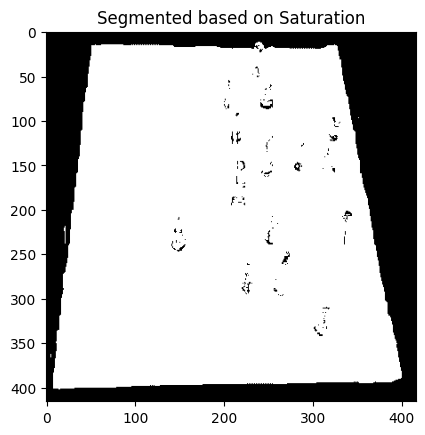

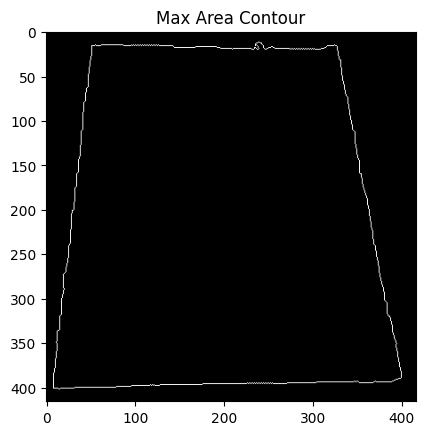

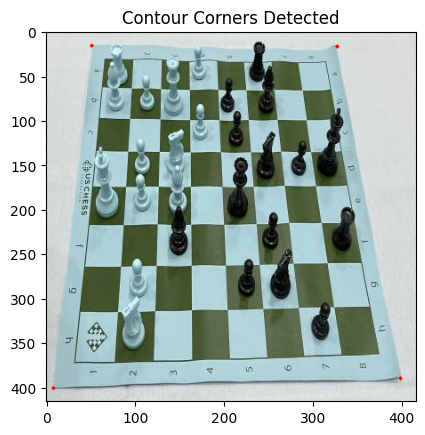

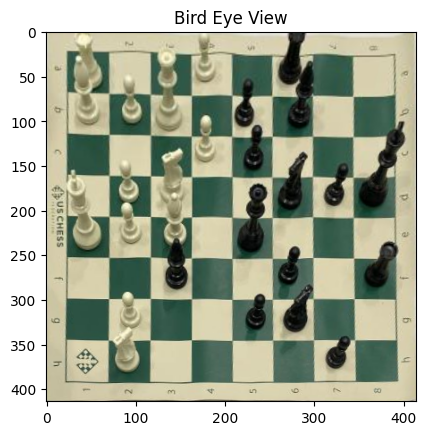

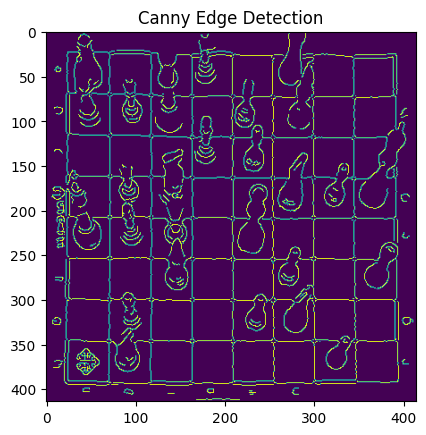

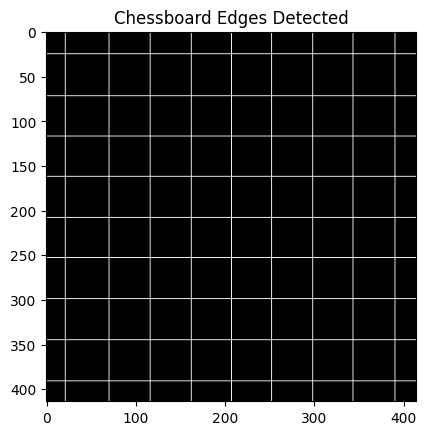

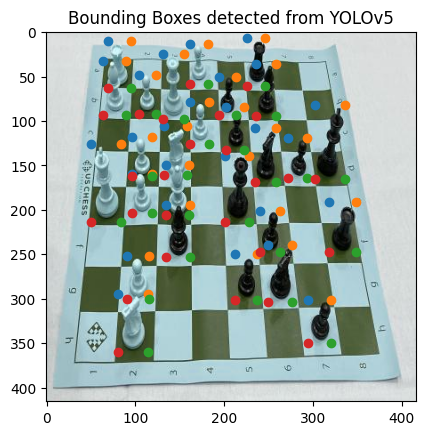

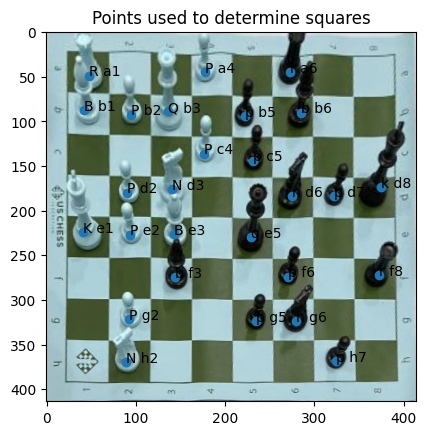

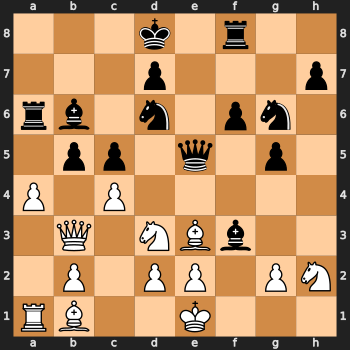

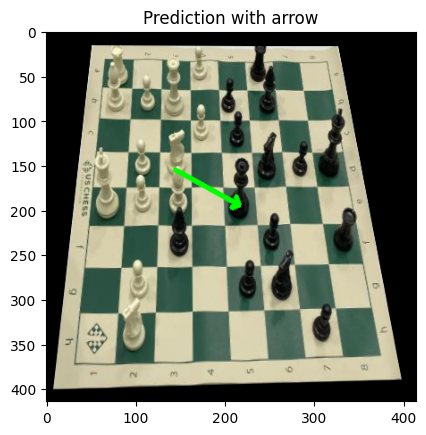

In [14]:
for img_path in sorted(os.listdir('dataset/test/images/')):
    # file_pth = img_path[:-4]
    file_pth = 'fdcd6ada676799da8a870f58fdf548db_jpg.rf.b0ea8552b6106bb4ab62ca8957fca40d'

    image = f"dataset/test/images/{file_pth}.jpg"
    label_txt = f'yolov5/runs/detect/exp/labels/{file_pth}.txt'
    pieceNames = ['_', 'b', 'k', 'n', 'p', 'q', 'r', 'B', 'K', 'N', 'P', 'Q', 'R']
    plt_flag = True

    img,cntrs,max_area_idx = loadSegmentImage(image, 15, plt_flag=plt_flag)
    cntr_crnr = getContourCorners(img, cntrs, max_area_idx, plt_flag=plt_flag)

    #Homography projection
    H = cv.getPerspectiveTransform(cntr_crnr.astype(np.float32), np.array([[0,0], [414,0], [0,414], [414,414]], np.float32))
    im_warped = cv.warpPerspective(np.copy(img), H, (414,414))
    if plt_flag:
        plt.imshow(cv.cvtColor(im_warped, cv.COLOR_BGR2RGB))
        plt.title('Bird Eye View')
        plt.show()
        
    lines_x, lines_y = fitLines(im_warped, plt_flag=plt_flag)

    with open(label_txt, 'r') as f:
        labels = np.loadtxt(f)
    labels = labels.reshape((-1, 5))

    bb_points = find_bounding_box_coords(labels, img, plt_flag=plt_flag)
    projected_bb_points = transform_bounding_box_coords(bb_points, H)
    board = fill_chessboard_squares(im_warped, projected_bb_points, labels, lines_x, lines_y, pieceNames, plt_flag=plt_flag)

    if plt_flag:
        display(SVG(chess.svg.board(board, size=350)))
        # with open(f"dataset/test/chessboard_svgs/{file_pth}.svg", 'w') as f:
        #     f.write(chess.svg.board(board, size=350))
    if chess.STATUS_NO_WHITE_KING not in board.status() and chess.STATUS_NO_BLACK_KING not in board.status() :
        chess_engine_generated_move(im_warped, board, H, lines_x, lines_y, file_pth, chess.WHITE, plt_flag=True)
    break


In [12]:
# for img_path in sorted(os.listdir('dataset/test/images/')):
#     print(img_path)
#     img = cv.cvtColor(cv.imread(f"dataset/test/images/{img_path}"), cv.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.show()